# Risk Contributions and Risk Parity

> The word 'risk' derives from the early Italian risicare, which means 'to dare'. In this sense, risk is a choice rather than a fate. The actions we dare to take, which depend on how free we are to make choices, are what the story of risk is all about.

_Peter L. Bernstein, Against the Gods: The Remarkable Story of Risk_

In [87]:
import numpy as np
import pandas as pd

import edhec_risk_kit_206 as erk

%load_ext autoreload
%autoreload 2
inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["2014":]
ind_mcap = erk.get_ind_market_caps(49, weights=True)["2014":]


w_cap=ind_mcap.iloc[0]
w_eq=erk.weight_ew(ind_rets)
rets = ind_rets
cov = rets.cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = erk.portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

Util     0.005916
Smoke    0.009393
Hshld    0.010492
Beer     0.010500
Food     0.011227
Soda     0.012041
Gold     0.012449
Clths    0.012855
Meals    0.013261
Telcm    0.015910
Other    0.015948
Guns     0.015950
Agric    0.016982
Hlth     0.017251
Softw    0.017357
MedEq    0.017747
Insur    0.018249
Rtail    0.019039
Drugs    0.019058
PerSv    0.019258
Chips    0.020140
Hardw    0.020570
BusSv    0.020757
Whlsl    0.020881
Paper    0.021104
Aero     0.021306
LabEq    0.021497
Rubbr    0.021541
Banks    0.021622
Fun      0.022200
Fin      0.022416
Trans    0.022935
Autos    0.023338
Toys     0.023371
Oil      0.023372
Cnstr    0.024585
Books    0.024772
Boxes    0.025176
Chems    0.026042
ElcEq    0.026376
Txtls    0.026679
RlEst    0.026693
FabPr    0.027473
Mach     0.027558
BldMt    0.028106
Mines    0.028641
Coal     0.029025
Ships    0.030005
Steel    0.030938
dtype: float64

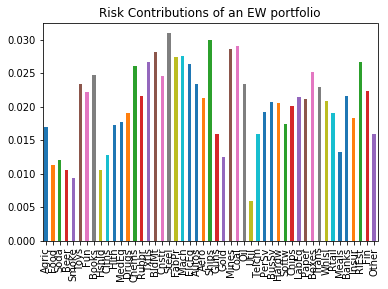

In [90]:
erc=risk_contribution(w_eq, cov)
erc.plot.bar(title="Risk Contributions of an EW portfolio")
erc.sort_values()

In [71]:
from scipy.optimize import minimize

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)


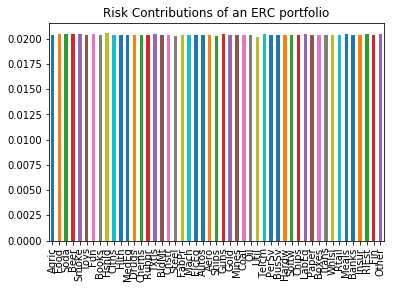

In [72]:
risk_contribution(equal_risk_contributions(cov), cov).plot.bar(title="Risk Contributions of an ERC portfolio");

In [73]:
def weight_erc(r, cov_estimator=erk.sample_cov, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)


In [79]:
erc_weight=weight_erc(ind_rets,cov_estimator=erk.sample_cov)
pd.Series(erc_weight,index=w_cap.index).sort_values()

Steel    0.012809
Ships    0.013041
BldMt    0.013790
Mines    0.013951
Mach     0.014292
RlEst    0.014429
Txtls    0.014440
ElcEq    0.014747
Coal     0.014759
Chems    0.014918
FabPr    0.015183
Boxes    0.015247
Books    0.015425
Cnstr    0.015924
Toys     0.016271
Autos    0.016726
Trans    0.016763
Oil      0.016764
Fun      0.017663
Rubbr    0.017747
LabEq    0.017751
Paper    0.017761
Fin      0.017833
Aero     0.017984
Whlsl    0.018421
Banks    0.018445
BusSv    0.018456
Hardw    0.018654
Chips    0.018878
Rtail    0.019567
Drugs    0.019730
PerSv    0.019924
MedEq    0.020907
Insur    0.020970
Softw    0.021963
Hlth     0.022246
Agric    0.022479
Telcm    0.023133
Other    0.023423
Guns     0.023809
Gold     0.027282
Meals    0.027907
Soda     0.028233
Clths    0.029129
Food     0.030251
Beer     0.032028
Smoke    0.032606
Hshld    0.033184
Util     0.052156
dtype: float64

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.048561,0.116542,-1.798291,5.857104,0.062586,0.088072,0.154861,-0.150361
CW,0.076372,0.115946,-1.591494,5.359304,0.058895,0.081560,0.389123,-0.138680


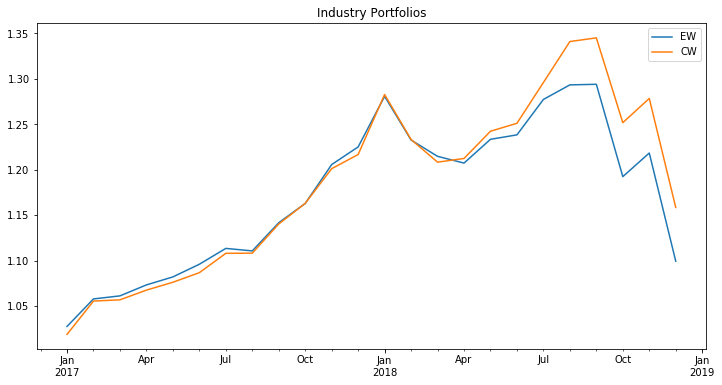

In [66]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

Now, let's run a backtest of this new weighting scheme we've just developed. Be warned that this will likely take quite some time to run - depending on your computer's CPU horsepower, but on my laptop it took several minutes.

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.121052,0.161000,-0.769256,6.572680,0.071993,0.103950,0.550248,-0.528292
CW,0.117007,0.149311,-0.702445,5.458192,0.066685,0.096232,0.566996,-0.518076
ERC-Sample,0.120185,0.149185,-0.872577,7.019237,0.066886,0.096357,0.588203,-0.502950


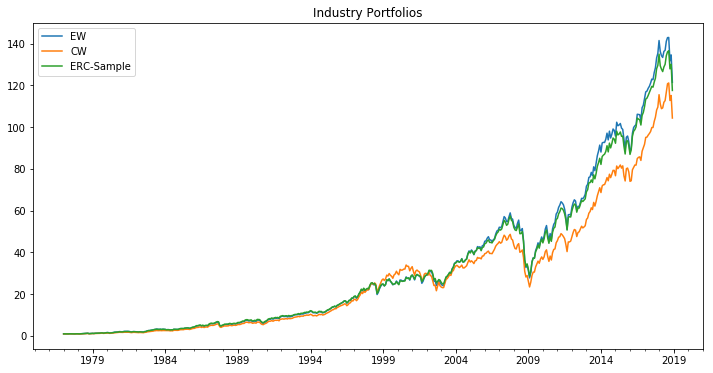

In [8]:
mv_erc_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_erc, cov_estimator=erk.sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "ERC-Sample": mv_erc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())